# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygadgetreader as gadred
from astropy.io import fits
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
from joblib import Parallel, delayed
import multiprocessing
import time

In [2]:
def density_map(posxy, gal_prop, x_c, y_c, method='mean', scpix=1, ima_size=[150,150]):
    
    gal_den=np.zeros((ima_size[1],ima_size[0]))*np.nan

    x_c = (ima_size[0]*0.5)*scpix-x_c
    y_c = (ima_size[1]*0.5)*scpix-y_c
    
    for ind, e in np.ndenumerate(gal_den):        
        cond = ((posxy[:,1] > ind[0]*scpix-y_c)  & (posxy[:,1] < ind[0]*scpix-y_c+scpix) & 
                (posxy[:,0] > ind[1]*scpix-x_c)  & (posxy[:,0] < ind[1]*scpix-x_c +scpix) )
        if method == 'mean':
            gal_den[ind] = np.nanmean(gal_prop[cond])
        else:
            gal_den[ind] = np.nansum(gal_prop[cond])
            
    if method == 'sum':
        gal_den[gal_den==0.0]=np.nan
    
    return gal_den

In [3]:
def grid_calc (ind, gal_prop, posxy, method, x_c, y_c, scpix):
    cond = ((posxy[:,1] > ind[0]*scpix-y_c)  & (posxy[:,1] < ind[0]*scpix-y_c+scpix) & 
                (posxy[:,0] > ind[1]*scpix-x_c)  & (posxy[:,0] < ind[1]*scpix-x_c +scpix) )
    if method == 'mean':
        return ind, np.nanmean(gal_prop[cond])
    else:
        return ind, np.nansum(gal_prop[cond])

In [4]:
def density_map_par(posxy, gal_prop, x_c, y_c, method='mean', scpix=1, ima_size=[150,150],
                    num_cores = multiprocessing.cpu_count()):
    
    gal_den=np.zeros((ima_size[1],ima_size[0]))*np.nan

    x_c = (ima_size[0]*0.5)*scpix-x_c
    y_c = (ima_size[1]*0.5)*scpix-y_c
    
    
    results=Parallel(n_jobs=num_cores)(delayed(grid_calc)(ind, gal_prop, 
             posxy, method, x_c, y_c, scpix) for ind, e in np.ndenumerate(gal_den))
                                 
    ind, valg = zip(*results)    
    ind = np.array(ind)
    gal_den[ind[:,0], ind[:,1]] = valg
    if method == 'sum':
        gal_den[gal_den==0.0]=np.nan
    
    return gal_den

# Loading the Snapshots

In [100]:
name = 'orb63'

snapshot = '../queorbita/orbits_22th_attempt/' + name + '/GADGET-OUTPUT/snapshot_110'

gadred.readheader(snapshot,'header')

{'npartThisFile': array([142176, 200000,  25000,   2500,   7824,      0], dtype=uint32),
 'npartTotal': array([142176, 200000,  25000,   2500,   7824,      0], dtype=uint32),
 'npartTotalHW': array([0, 0, 0, 0, 0, 0], dtype=uint32),
 'ngas': 142176,
 'ndm': 200000,
 'ndisk': 25000,
 'nbulge': 2500,
 'nstar': 7824,
 'nbndry': 0,
 'massTable': array([0., 0., 0., 0., 0., 0.]),
 'time': 1.1015625e+00,
 'nfiles': 1,
 'redshift': 0.0,
 'boxsize': 1000000.0,
 'O0': 0.0,
 'Ol': 0.0,
 'h': 0.7,
 'flag_cooling': 1,
 'flag_sfr': 1,
 'flag_fb': 1,
 'flag_fh2': 0,
 'flag_age': 0,
 'flag_metals': 1,
 'flag_potential': 0,
 'flag_delaytime': 0,
 'flag_tmax': 0,
 'rhocrit': 0.0}

In [101]:
gas_vel = gadred.readsnap(snapshot,'vel','gas')
gas_pos = gadred.readsnap(snapshot,'pos','gas')
gas_mass = gadred.readsnap(snapshot,'mass','gas')
disk_pos = gadred.readsnap(snapshot,'pos','disk')
disk_mass = gadred.readsnap(snapshot,'mass','disk')

Returning GAS   Velocities
Returning GAS   Positions
Returning GAS   Mass
Returning DISK  Positions
Returning DISK  Mass


# Stars

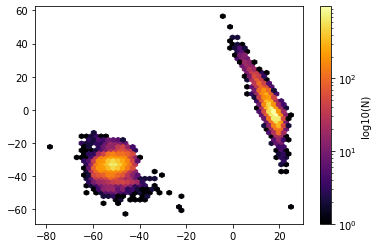

In [102]:
hb = plt.hexbin(disk_pos[:,0],disk_pos[:,1], gridsize=50, bins='log', cmap='inferno')
cb = plt.colorbar(hb)
cb.set_label('log10(N)')

# Gas

(-62.80242156982422, 56.4469108581543)

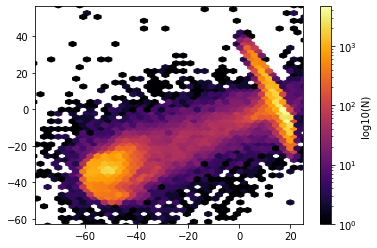

In [103]:
%matplotlib inline
hb = plt.hexbin(gas_pos[:,0],gas_pos[:,1], gridsize=1000, bins='log', cmap='inferno')
cb = plt.colorbar(hb)
cb.set_label('log10(N)')
limx = np.percentile(disk_pos[:,0], [0,100])
limy = np.percentile(disk_pos[:,1], [0,100])
plt.xlim(limx)
plt.ylim(limy)

# Determining the center of the image

(-62.80242156982422, 56.4469108581543)

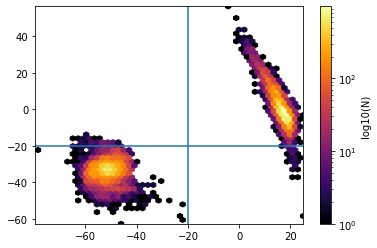

In [104]:
xcent = -20
ycent = -20

plt.vlines(xcent,limy[0], limy[1])
plt.hlines(ycent,limx[0], limx[1])

hb = plt.hexbin(disk_pos[:,0],disk_pos[:,1], gridsize=50, bins='log', cmap='inferno')
cb = plt.colorbar(hb)
cb.set_label('log10(N)')
plt.xlim(limx)
plt.ylim(limy)

# Making Star and gas images

## Running in a single core

In [ ]:
dimx = 300
dimy = 300

start_time = time.time()

map_rad_vel = density_map(gas_pos, gas_vel[:,2] , xcent, ycent, ima_size=[dimx, dimy], scpix=0.5)
map_star=density_map(disk_pos, disk_mass, xcent, ycent, 'sum', ima_size=[dimx, dimy], scpix=0.5)
map_gas=density_map(gas_pos, gas_mass, xcent, ycent, 'sum', ima_size=[75, 75], scpix=2)

timet=(time.time() - start_time)/60.0                                       
print ('Time total lapsed:')                                                
print ('%2.1f' %(np.fix(timet)), 'minutes', '%2.1f' %((timet-np.fix(timet))*60.0),
       'seconds')   

## Running in parallel

In [105]:
dimx = 300
dimy = 300
scpix = 0.5
num_cores=8

start_time = time.time()

map_rad_vel = density_map_par(gas_pos, gas_vel[:,2] , xcent, ycent, ima_size=[dimx, dimy], scpix=scpix,
                              num_cores=num_cores)
map_star=density_map_par(disk_pos, disk_mass, xcent, ycent, 'sum', ima_size=[dimx, dimy], scpix=scpix,
                         num_cores=num_cores)
map_gas=density_map_par(gas_pos, gas_mass, xcent, ycent, 'sum', ima_size=[75, 75], scpix=scpix*4,
                        num_cores=num_cores)

timet=(time.time() - start_time)/60.0 

print ('Time total lapsed:')                                                
print ('%2.1f' %(np.fix(timet)), 'minutes', '%2.1f' %((timet-np.fix(timet))*60.0),
       'seconds')                                                           


/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: 

/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: 

/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_27779/1812202122.py:5: 

Time total lapsed:
0.0 minutes 6.6 seconds


# Radial Velocity map

<IPython.core.display.Javascript object>


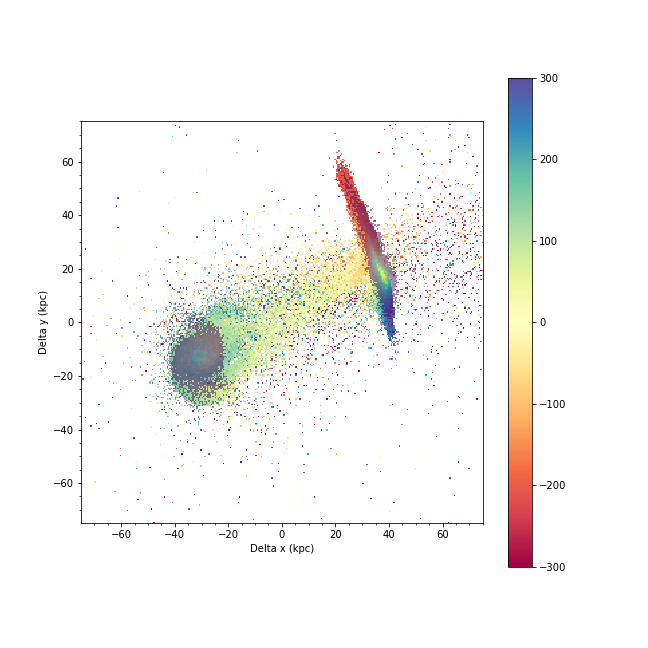

In [106]:
%matplotlib nbagg
plt.figure(figsize=(9,9))
cb=plt.imshow(-map_rad_vel, origin='lower', cmap='Spectral', vmin=-300, vmax=300, interpolation='none',
             extent=np.array([-dimx,dimx,-dimy,dimy])*scpix*0.5)

cb = plt.colorbar(cb)

plt.imshow(map_star, origin='lower', vmin=np.nanpercentile(map_star,10), alpha=0.5,
                                     vmax=np.nanpercentile(map_star,99.8), interpolation='none',
           extent=np.array([-dimx,dimx,-dimy,dimy])*scpix*0.5)



plt.minorticks_on()
plt.xlabel("Delta x (kpc)")
plt.ylabel("Delta y (kpc)")

plt.savefig('../Figures/orbits_22th_attempt/velocity'+ name)

# Star and gas Maps

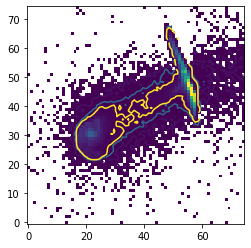

In [107]:
%matplotlib inline
plt.imshow(map_gas, origin='lower', vmin=np.nanpercentile(map_gas,10), alpha=1,
                                     vmax=np.nanpercentile(map_gas,99.8), interpolation='none')

plt.contour(map_gas, np.nanpercentile(map_gas,[40,50,70,80]), origin='lower',)

plt.savefig('../Figures/orbits_22th_attempt/map_gas-'+ name)

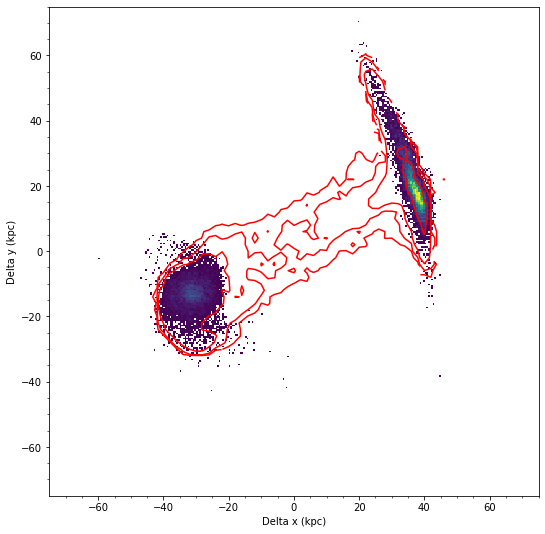

In [108]:
%matplotlib inline
plt.figure(figsize=(9,9))

plt.imshow(map_star, origin='lower', vmin=np.nanpercentile(map_star,10), cmap='viridis',
                                     vmax=np.nanpercentile(map_star,99.8), interpolation='none',
           extent=np.array([-dimx,dimx,-dimy,dimy])*0.5*scpix)



kernel = Gaussian2DKernel(x_stddev=0.2)
smooth = convolve(map_gas, kernel)
smooth[np.isnan(map_gas)]=np.nan

plt.contour(smooth, np.nanpercentile(smooth,[70,80,90,99]), origin='lower', 
            extent=np.array([-dimx,dimx,-dimy,dimy])*0.5*scpix, colors='red')

plt.minorticks_on()
plt.xlabel("Delta x (kpc)")
plt.ylabel("Delta y (kpc)")

plt.savefig('../Figures/orbits_22th_attempt/map_star-'+ name)